In [1]:

import sys
sys.path.insert(1,"/home1/07064/tg863631/anaconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages") #work around for h5py
from cbrain.imports import *
from cbrain.cam_constants import *
from cbrain.utils import *
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
import tensorflow as tf
from tensorflow import math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_probability as tfp
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
# import cartopy.crs as ccrs
import matplotlib.ticker as mticker
# from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pickle
from climate_invariant import *
from tensorflow.keras import layers
import datetime



## Data Generators

In [104]:
TRAINDIR = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'
path = '/home/ankitesh/CBrain_project/CBRAIN-CAM/cbrain/'
path_hyam = 'hyam_hybm.pkl'

hf = open(path+path_hyam,'rb')
hyam,hybm = pickle.load(hf)


In [105]:
TRAINFILE = 'CI_SP_M4K_train_shuffle.nc'
NORMFILE = 'CI_SP_M4K_NORM_norm.nc'
VALIDFILE = 'CI_SP_M4K_valid.nc'

In [106]:
scale_dict = load_pickle('/home/ankitesh/CBrain_project/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling.pkl')
in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

In [107]:
train_gen = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True
)

In [84]:
valid_gen = DataGenerator(
    data_fn = TRAINDIR+VALIDFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True
)

In [85]:
TRAINFILE = 'CI_SP_P4K_train_shuffle.nc'
NORMFILE = 'CI_SP_P4K_NORM_norm.nc'
VALIDFILE = 'CI_SP_P4K_valid.nc'

In [86]:
train_gen_p4k = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=False
)

### Generators using RH Inputs

In [9]:
scale_dict_RH = load_pickle('/home/ankitesh/CBrain_project/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling.pkl')

In [10]:
scale_dict_RH['RH'] = 0.01*L_S/G, # Arbitrary 0.1 factor as specific humidity is generally below 2%

In [11]:
in_vars_RH = ['RH','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars_RH = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

In [12]:
TRAINFILE_RH = 'CI_RH_M4K_NORM_train_shuffle.nc'
NORMFILE_RH = 'CI_RH_M4K_NORM_norm.nc'
VALIDFILE_RH = 'CI_RH_M4K_NORM_valid.nc'

In [13]:
train_gen_RH = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE_RH,
    input_vars = in_vars_RH,
    output_vars = out_vars_RH,
    norm_fn = TRAINDIR+NORMFILE_RH,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_RH,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True
)

### Generators using T-TNS Inputs

In [14]:
in_vars = ['QBP','TfromNS','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

In [15]:
TRAINFILE_TNS = 'CI_TNS_M4K_NORM_train_shuffle.nc'
NORMFILE_TNS = 'CI_TNS_M4K_NORM_norm.nc'
VALIDFILE_TNS = 'CI_TNS_M4K_NORM_valid.nc'

In [16]:
train_gen_TNS = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE_TNS,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE_TNS,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True
)

## Shifting Level coordinate system

### Playing with the data 

In [17]:
When you scale the outputs, all you need to rescale is PHQ [:,:30] and TPHYSTND [:,30:60]

SyntaxError: invalid syntax (<ipython-input-17-1a079876c723>, line 1)

In [22]:
X = train_gen[0][0]

In [18]:
X.shape

(1024, 64)

In [19]:
T = X[:,30:60]

In [20]:
T[0]

array([244.88736, 234.0175 , 218.0285 , 238.08168, 230.21843, 224.06192,
       220.3527 , 219.2639 , 217.8777 , 216.15045, 214.42757, 210.79518,
       205.68257, 203.42181, 209.44202, 218.26942, 226.97742, 236.22296,
       245.35803, 252.20699, 257.76736, 261.90103, 264.6378 , 265.97977,
       266.65848, 267.95245, 269.53882, 271.18634, 272.70816, 274.13736],
      dtype=float32)

In [21]:
### Let's plot it,

In [17]:
# Load coordinates (just pick any file from the climate model run)
coor = xr.open_dataset("/oasis/scratch/comet/ankitesh/temp_project/data/sp8fbp_minus4k.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon; lev = coor.lev;
coor.close();

In [18]:
lev

<xarray.DataArray 'lev' (lev: 30)>
array([  3.643466,   7.59482 ,  14.356632,  24.61222 ,  38.2683  ,  54.59548 ,
        72.012451,  87.82123 , 103.317127, 121.547241, 142.994039, 168.22508 ,
       197.908087, 232.828619, 273.910817, 322.241902, 379.100904, 445.992574,
       524.687175, 609.778695, 691.38943 , 763.404481, 820.858369, 859.534767,
       887.020249, 912.644547, 936.198398, 957.48548 , 976.325407, 992.556095])
Coordinates:
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
Attributes:
    long_name:      hybrid level at midpoints (1000*(A+B))
    units:          level
    positive:       down
    standard_name:  atmosphere_hybrid_sigma_pressure_coordinate
    formula_terms:  a: hyam b: hybm p0: P0 ps: PS

In [24]:
lat

<xarray.DataArray 'lat' (lat: 64)>
array([-87.863799, -85.096527, -82.312913, -79.525607, -76.7369  , -73.947515,
       -71.157752, -68.367756, -65.577607, -62.787352, -59.99702 , -57.206632,
       -54.4162  , -51.625734, -48.835241, -46.044727, -43.254195, -40.463648,
       -37.67309 , -34.882521, -32.091944, -29.30136 , -26.510769, -23.720174,
       -20.929574, -18.138971, -15.348365, -12.557756,  -9.767146,  -6.976534,
        -4.185921,  -1.395307,   1.395307,   4.185921,   6.976534,   9.767146,
        12.557756,  15.348365,  18.138971,  20.929574,  23.720174,  26.510769,
        29.30136 ,  32.091944,  34.882521,  37.67309 ,  40.463648,  43.254195,
        46.044727,  48.835241,  51.625734,  54.4162  ,  57.206632,  59.99702 ,
        62.787352,  65.577607,  68.367756,  71.157752,  73.947515,  76.7369  ,
        79.525607,  82.312913,  85.096527,  87.863799])
Coordinates:
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
Attributes:
    long_name:  latitude
    units:      degrees_north

Text(0, 0.5, 'lev')

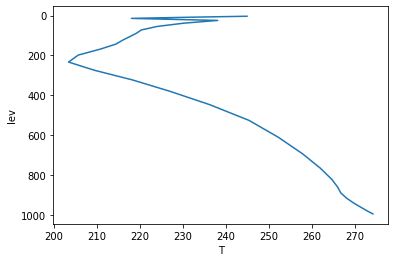

In [25]:
plt.plot(T[0],lev)
plt.gca().invert_yaxis()
plt.xlabel('T')
plt.ylabel('lev')

Text(0, 0.5, 'lev')

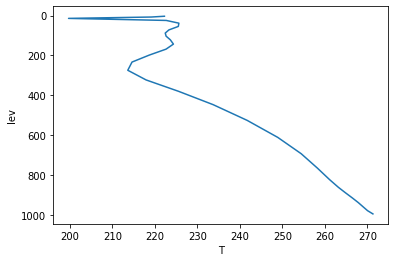

In [26]:
plt.plot(T[1],lev)
plt.gca().invert_yaxis()
plt.xlabel('T')
plt.ylabel('lev')

Text(0, 0.5, 'lev')

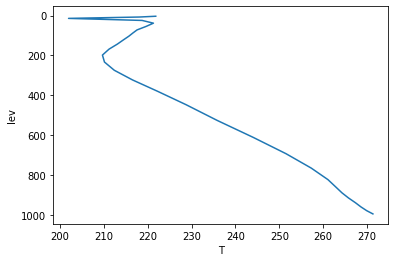

In [27]:
plt.plot(T[2],lev)
plt.gca().invert_yaxis()
plt.xlabel('T')
plt.ylabel('lev')

In [28]:
## plan to calculate min
import numpy
import math

In [29]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """


    if window_len<3:
        return x


    s=numpy.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y[math.ceil(window_len/2-1):-int(window_len/2)]

In [30]:
smoothened = smooth(T[2])
T[2].shape
smoothened.shape

(30,)

Text(0, 0.5, 'lev')

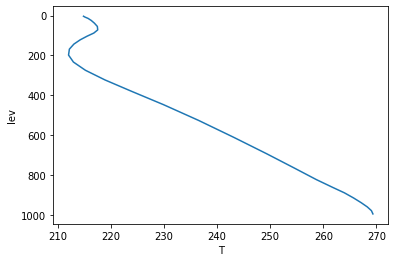

In [31]:
plt.plot(smoothened,lev)
plt.gca().invert_yaxis()
plt.xlabel('T')
plt.ylabel('lev')

In [32]:
imin = np.argmin(smoothened)


In [33]:
imin

12

In [34]:
## let's take it between 100-400pa (start from the 6th index)

In [35]:
imin = np.argmin(T[1][6:])+6

In [36]:
imin

14

In [37]:
lev

<xarray.DataArray 'lev' (lev: 30)>
array([  3.643466,   7.59482 ,  14.356632,  24.61222 ,  38.2683  ,  54.59548 ,
        72.012451,  87.82123 , 103.317127, 121.547241, 142.994039, 168.22508 ,
       197.908087, 232.828619, 273.910817, 322.241902, 379.100904, 445.992574,
       524.687175, 609.778695, 691.38943 , 763.404481, 820.858369, 859.534767,
       887.020249, 912.644547, 936.198398, 957.48548 , 976.325407, 992.556095])
Coordinates:
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
Attributes:
    long_name:      hybrid level at midpoints (1000*(A+B))
    units:          level
    positive:       down
    standard_name:  atmosphere_hybrid_sigma_pressure_coordinate
    formula_terms:  a: hyam b: hybm p0: P0 ps: PS

In [38]:
T.shape

(1024, 30)

In [25]:
levroof_ind_m4k = np.argmin(T[:,6:],axis=1)+6

Text(0, 0.5, 'lev')

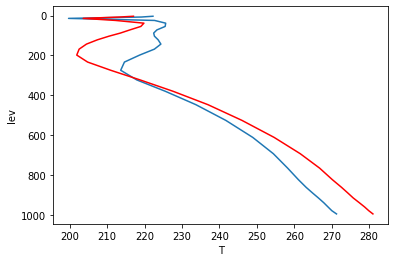

In [91]:
plt.plot(T[1],lev)
plt.plot(Tp4k[1],lev, color='r')
plt.gca().invert_yaxis()
plt.xlabel('T')
plt.ylabel('lev')

In [50]:
X_p4 = train_gen_p4k[0][0]
print(X_p4.shape)
Tp4k = X_p4[:,30:60]

(1024, 64)


In [51]:
levroof_ind_p4k = np.argmin(Tp4k[:,6:],axis=1)+6

In [52]:
levroof_ind_p4k

array([12, 12, 13, ...,  6,  6,  7])

In [53]:
lev_roof = np.array(lev[levroof_ind_p4k])

In [54]:
lev_roof.shape

(1024,)

In [55]:
lev

<xarray.DataArray 'lev' (lev: 30)>
array([  3.643466,   7.59482 ,  14.356632,  24.61222 ,  38.2683  ,  54.59548 ,
        72.012451,  87.82123 , 103.317127, 121.547241, 142.994039, 168.22508 ,
       197.908087, 232.828619, 273.910817, 322.241902, 379.100904, 445.992574,
       524.687175, 609.778695, 691.38943 , 763.404481, 820.858369, 859.534767,
       887.020249, 912.644547, 936.198398, 957.48548 , 976.325407, 992.556095])
Coordinates:
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
Attributes:
    long_name:      hybrid level at midpoints (1000*(A+B))
    units:          level
    positive:       down
    standard_name:  atmosphere_hybrid_sigma_pressure_coordinate
    formula_terms:  a: hyam b: hybm p0: P0 ps: PS

In [56]:
lev_stacked = np.repeat(np.array(lev).reshape(1,-1),1024,axis=0)

In [60]:
lev_stacked[:,-1].reshape(-1,1)

array([[992.55609512],
       [992.55609512],
       [992.55609512],
       ...,
       [992.55609512],
       [992.55609512],
       [992.55609512]])

In [67]:
lev_stacked[:,-1].shape

(1024,)

In [69]:
lev_tilde = (lev_stacked[:,-1].reshape(-1,1)-lev_stacked[:])/(lev_stacked[:,-1].reshape(-1,1)-lev_roof.reshape(-1,1))

In [70]:
lev_tilde[0]

array([1.24446625, 1.23949379, 1.2309846 , 1.21807878, 1.20089371,
       1.18034728, 1.15842944, 1.13853537, 1.11903504, 1.09609392,
       1.06910487, 1.03735365, 1.        , 0.95605535, 0.90435673,
       0.84353599, 0.77198355, 0.68780581, 0.58877505, 0.48169428,
       0.3789938 , 0.2883687 , 0.21606765, 0.16739654, 0.13280829,
       0.1005622 , 0.07092159, 0.04413352, 0.020425  , 0.        ])

In [105]:
np.diff(np.flip(lev_tilde[0]))

array([0.020425  , 0.02370852, 0.02678806, 0.02964061, 0.0322461 ,
       0.03458825, 0.04867111, 0.07230105, 0.09062509, 0.10270048,
       0.10708077, 0.09903077, 0.08417774, 0.07155244, 0.06082075,
       0.05169861, 0.04394465, 0.03735365, 0.03175122, 0.02698905,
       0.02294112, 0.01950033, 0.01989407, 0.02191784, 0.02054643,
       0.01718507, 0.01290582, 0.00850919, 0.00497246])

In [118]:
np.diff(np.flip(lev_tilde[2]))

array([0.02136383, 0.02479827, 0.02801936, 0.03100303, 0.03372828,
       0.03617808, 0.05090825, 0.07562434, 0.09479064, 0.10742107,
       0.11200269, 0.10358267, 0.08804693, 0.07484131, 0.06361635,
       0.05407491, 0.04596455, 0.0390706 , 0.03321065, 0.02822959,
       0.0239956 , 0.02039665, 0.02080849, 0.02292529, 0.02149084,
       0.01797497, 0.01349903, 0.00890031, 0.00520101])

In [116]:
23*(max(lev_tilde[0]) - min(lev_tilde[0]))/(29)

0.9869904764529444

In [90]:
lev_tilde[2]

array([1.30166759, 1.29646657, 1.28756626, 1.27406722, 1.25609225,
       1.23460141, 1.21167613, 1.19086764, 1.17047099, 1.14647539,
       1.1182458 , 1.08503515, 1.04596455, 1.        , 0.94592509,
       0.88230874, 0.80746743, 0.7194205 , 0.61583783, 0.50383514,
       0.39641408, 0.30162344, 0.2259991 , 0.17509085, 0.13891277,
       0.10518449, 0.07418146, 0.0461621 , 0.02136383, 0.        ])

In [72]:
Tp4k[0]

array([246.58046, 235.4533 , 219.39764, 236.5129 , 238.76416, 230.05035,
       226.72517, 224.5787 , 222.51593, 220.19954, 216.8819 , 214.54407,
       214.3332 , 216.61076, 222.03326, 229.59703, 237.86671, 245.74434,
       253.37877, 259.54178, 264.43524, 267.59473, 269.64905, 272.3245 ,
       273.86365, 275.5593 , 277.13327, 278.65292, 279.77493, 281.05084],
      dtype=float32)

AttributeError: 'numpy.ndarray' object has no attribute 'reverse'

In [91]:
lev_tilde_after = np.linspace(1.4,0,num=40)

In [92]:
lev_tilde_after

array([1.4       , 1.36410256, 1.32820513, 1.29230769, 1.25641026,
       1.22051282, 1.18461538, 1.14871795, 1.11282051, 1.07692308,
       1.04102564, 1.00512821, 0.96923077, 0.93333333, 0.8974359 ,
       0.86153846, 0.82564103, 0.78974359, 0.75384615, 0.71794872,
       0.68205128, 0.64615385, 0.61025641, 0.57435897, 0.53846154,
       0.5025641 , 0.46666667, 0.43076923, 0.39487179, 0.35897436,
       0.32307692, 0.28717949, 0.25128205, 0.21538462, 0.17948718,
       0.14358974, 0.10769231, 0.07179487, 0.03589744, 0.        ])

In [93]:
t_after = np.interp(lev_tilde_after, np.flip(lev_tilde[0]), np.flip(Tp4k[0]))

print(t_after)

[246.58045959 246.58045959 246.58045959 246.58045959 246.58045959
 233.28495242 231.86047064 225.67735352 221.88844192 217.84295366
 214.81443433 214.36215487 215.92790954 218.99400216 222.89395071
 227.3582139  231.66524363 235.81409527 239.5640707  242.92346873
 246.18796454 248.9553516  251.72273866 254.20848288 256.27455175
 258.34062061 260.25781289 261.96825058 263.67868826 265.13318422
 266.38468532 267.62851622 268.64848569 269.6865941  271.65987234
 273.38388011 275.18436154 277.08689704 279.04269762 281.05084229]


In [94]:
t_after = np.interp(lev_tilde_after, np.flip(lev_tilde[2]), np.flip(Tp4k[2]))

print(t_after)

[218.98272705 218.98272705 218.98272705 210.3196121  228.92295153
 232.45727172 233.8628857  231.69858463 227.71484519 223.77866004
 220.82988394 219.56736808 220.06061699 221.40806751 223.79491813
 226.7579683  230.14066911 233.52622413 236.91470578 240.27189161
 242.89705394 245.52221627 248.04034543 249.97711366 251.91388188
 253.84966594 255.75863865 257.66761135 259.58027092 261.5750573
 263.56984369 265.50816509 267.36261949 269.13419032 270.70833837
 272.35237315 274.31746721 276.21518138 277.80524083 279.78311157]


In [98]:
lev_tilde_after_stacked = np.repeat(lev_tilde_after.reshape(1,-1),1024,axis=0)

In [101]:
lev_tilde_after_stacked.shape

(1024, 40)

In [103]:
t_after = np.interp(lev_tilde_after, np.flip(lev_tilde[2]), np.flip(Tp4k[2]))

print(t_after)

[218.98272705 218.98272705 218.98272705 210.3196121  228.92295153
 232.45727172 233.8628857  231.69858463 227.71484519 223.77866004
 220.82988394 219.56736808 220.06061699 221.40806751 223.79491813
 226.7579683  230.14066911 233.52622413 236.91470578 240.27189161
 242.89705394 245.52221627 248.04034543 249.97711366 251.91388188
 253.84966594 255.75863865 257.66761135 259.58027092 261.5750573
 263.56984369 265.50816509 267.36261949 269.13419032 270.70833837
 272.35237315 274.31746721 276.21518138 277.80524083 279.78311157]


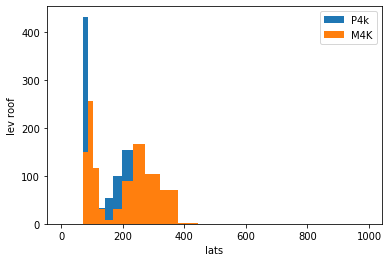

In [109]:
plt.hist(lev[levroof_ind_p4k],bins=lev, label="P4k")
plt.hist(lev[levroof_ind_m4k],bins=lev, label="M4K")
plt.xlabel("lats")
plt.ylabel("lev roof")
plt.legend()

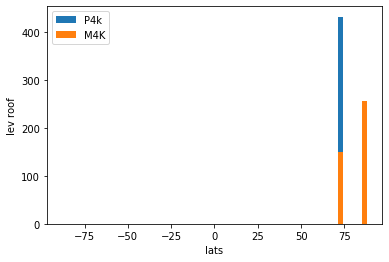

In [29]:
plt.hist(lev[levroof_ind_p4k],bins=lat, label="P4k")
plt.hist(lev[levroof_ind_m4k],bins=lat, label="M4K")
plt.xlabel("lats")
plt.ylabel("lev roof")
plt.legend()

### Building componets

In [33]:
### for fast prototyping lets's override the data generator class
##becasue tensorflow doen't provide irregular interval interpolation

In [74]:

class DataGeneratorTilde(DataGenerator):
    
    def __init__(self, data_fn, input_vars, output_vars,
             norm_fn=None, input_transform=None, output_transform=None,
             batch_size=1024, shuffle=True, xarray=False, var_cut_off=None, normalize_flag=True, lev=None
                ,hyam=None,hybm=None,
                inp_sub=None, inp_div=None,
                inp_subRH=None,inp_divRH=None,
                inp_subTNS=None,inp_divTNS=None):
        
        self.lev = lev
        self.hyam = hyam
        self.hybm = hybm
        self.inp_sub = np.array(inp_sub)
        self.inp_div = np.array(inp_div)
        self.inp_subRH = np.array(inp_subRH)
        self.inp_divRH = np.array(inp_divRH)
        self.inp_subTNS = np.array(inp_subTNS)
        self.inp_divTNS = np.array(inp_divTNS)
        self.QBP_idx = slice(0,30)
        self.TBP_idx = slice(30,60)
        self.PS_idx = 60
        self.SHFLX_idx = 62
        self.LHFLX_idx = 63

        
        super().__init__(data_fn, input_vars,output_vars,norm_fn,input_transform,output_transform,
                        batch_size,shuffle,xarray,var_cut_off,normalize_flag)
        
        
        
    def __getitem__(self, index):
        # Compute start and end indices for batch
        start_idx = index * self.batch_size
        end_idx = start_idx + self.batch_size

        # Grab batch from data
        batch = self.data_ds['vars'][start_idx:end_idx]

        # Split into inputs and outputs
        X = batch[:, self.input_idxs]
        Y = batch[:, self.output_idxs]
        batch_size = X.shape[0]
        ## addtions for level tilde
        X_temperature = batch[:,30:60] #batchx30
        lev_stacked = lev_stacked = np.repeat(np.array(lev).reshape(1,-1),batch_size,axis=0)
        imin = np.argmin(X_temperature[:,6:],axis=1)+6
        lev_roof = np.array(self.lev[imin])
        lev_tilde = (lev_stacked[:,-1].reshape(-1,1)-lev_stacked[:])/(lev_stacked[:,-1].reshape(-1,1)-lev_roof.reshape(-1,1))#batchx30

        # Normalize
        X = self.input_transform.transform(X)
        Y = self.output_transform.transform(Y)
        
        
        #########calculate RH
        
        Tprior = X[:,self.TBP_idx]*self.inp_div[self.TBP_idx]+self.inp_sub[self.TBP_idx]
        qvprior = X[:,self.QBP_idx]*self.inp_div[self.QBP_idx]+self.inp_sub[self.QBP_idx]
        PSprior = X[:,self.PS_idx]*self.inp_div[self.PS_idx]+self.inp_sub[self.PS_idx]
        RHprior = (RHNumpy(Tprior,qvprior,P0,PSprior,self.hyam,self.hybm)-\
                    self.inp_subRH[self.QBP_idx])/self.inp_divRH[self.QBP_idx]
        
        X_result = np.concatenate([RHprior.astype(np.float32),X[:,30:]], axis=1)
        
        
        ##############calculate TNS
        
                
        Tprior = X_result[:,self.TBP_idx]*self.inp_div[self.TBP_idx]+self.inp_sub[self.TBP_idx]
        
        Tile_dim = [1,30]
        TNSprior = ((Tprior-np.tile(np.expand_dims(Tprior[:,-1],axis=1),Tile_dim))-\
                    self.inp_subTNS[self.TBP_idx])/\
        self.inp_divTNS[self.TBP_idx]
        
        post = np.concatenate([X_result[:,:30],TNSprior.astype(np.float32),X_result[:,60:]], axis=1)
        
        X_result = post
        
        ## calculate lev tilde after 
        X_temperature = X_result[:,30:60] #batchx30
        X_pressure = X_result[:,:30]
        lev_tilde_after_single = np.linspace(1.4,0,num=40)
        X_temperature_after = []
        X_pressure_after = []

        for i in range(batch_size):
            X_temperature_after.append(np.interp(lev_tilde_after_single, np.flip(lev_tilde[i]), np.flip(X_temperature[i])))
            X_pressure_after.append(np.interp(lev_tilde_after_single, np.flip(lev_tilde[i]), np.flip(X_pressure[i])))
        X_temperature_after = np.array(X_temperature_after) #batch_sizex340
        X_pressure_after = np.array(X_pressure_after) #batch_sizex40

        X_result = np.hstack((X_result,X_pressure_after)) #64 to 104 pressure after
        X_result = np.hstack((X_result,X_temperature_after)) #104 to 144 temp after
        X_result = np.hstack((X_result,X[:,60:64]))# 144 to 148 same as 60-64
        X_result = np.hstack((X_result,lev_tilde))# 148 to 178 will be required during revese transformation of coordinates.
        
        return xr.DataArray(np.array(X_result)), xr.DataArray(Y)

In [58]:
TRAINDIR = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'
path = '/home/ankitesh/CBrain_project/CBRAIN-CAM/cbrain/'
path_hyam = 'hyam_hybm.pkl'

hf = open(path+path_hyam,'rb')
hyam,hybm = pickle.load(hf)

TRAINFILE = 'CI_SP_M4K_train_shuffle.nc'
NORMFILE = 'CI_SP_M4K_NORM_norm.nc'
VALIDFILE = 'CI_SP_M4K_valid.nc'

scale_dict = load_pickle('/home/ankitesh/CBrain_project/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling.pkl')
in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']



In [59]:
train_gen_tilde = DataGeneratorTilde(
    data_fn = TRAINDIR+TRAINFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_sub=train_gen.input_transform.sub, inp_div=train_gen.input_transform.div,
    inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
    inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div
)



In [60]:
valid_gen_tilde = DataGeneratorTilde(
    data_fn = TRAINDIR+VALIDFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_sub=train_gen.input_transform.sub, inp_div=train_gen.input_transform.div,
    inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
    inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div
)

In [61]:
train_gen_tilde[0][0]

<xarray.DataArray (dim_0: 1024, dim_1: 178)>
array([[-0.0311502 , -0.02573541, -0.05786772, ...,  0.0461621 ,
         0.02136383,  0.        ],
       [-0.0307257 , -0.02452642, -0.04315853, ...,  0.04880101,
         0.02258512,  0.        ],
       [-0.03070704, -0.02430964, -0.04808075, ...,  0.04413352,
         0.020425  ,  0.        ],
       ...,
       [-0.03104536, -0.0249203 , -0.04674705, ...,  0.03876342,
         0.01793972,  0.        ],
       [-0.03109084, -0.02513316, -0.05344677, ...,  0.03876342,
         0.01793972,  0.        ],
       [-0.03070937, -0.02427977, -0.04706388, ...,  0.04026436,
         0.01863435,  0.        ]])
Dimensions without coordinates: dim_0, dim_1

In [ ]:
### Lev Tilde cal

In [132]:
def levTildeDiscrete(X,lev,batch_size=1024,interm_dim_size=40):
    
    X_denormalized = X*inp_div+inp_sub
    X_pressure = X[:,:30]
    X_temperature = X[:,30:60] #batchx30
    X_temperature_denomalized = X_denormalized[:,30:60]
    
    lev_stacked = lev_stacked = np.repeat(np.array(lev).reshape(1,-1),batch_size,axis=0)
    imin = np.argmin(X_temperature_denomalized[:,6:],axis=1)+6
    lev_roof = np.array(lev[imin])
    lev_tilde = (lev_stacked[:,-1].reshape(-1,1)-lev_stacked[:])/(lev_stacked[:,-1].reshape(-1,1)-lev_roof.reshape(-1,1))#batchx30

    
    lev_tilde_after_single = np.linspace(1.4,0,num=interm_dim_size)
    
    X_temperature_after = []
    X_pressure_after = []

    for i in range(batch_size):
        X_temperature_after.append(np.interp(lev_tilde_after_single, np.flip(lev_tilde[i]), np.flip(X_temperature[i])))
        X_pressure_after.append(np.interp(lev_tilde_after_single, np.flip(lev_tilde[i]), np.flip(X_pressure[i])))
    
    X_temperature_after = np.array(X_temperature_after)
    X_pressure_after = np.array(X_pressure_after)
    
    X_result = np.hstack((X_pressure_after,X_temperature_after))
    X_result = np.hstack((X_result,X[:,60:64]))
    
    return  X_result, lev_tilde, lev_roof
    

In [129]:
def levTildeConti(X,lev,inp_sub,inp_div,batch_size=1024,interm_dim_size=40,Tnot=5):
    
    X_denormalized = X*inp_div+inp_sub
    X_pressure = X[:,:30]
    X_temperature = X[:,30:60] #batchx30
    X_temperature_denormalized = X_denormalized[:,30:60]
    lev_stacked = lev_stacked = np.repeat(np.array(lev).reshape(1,-1),batch_size,axis=0)
    imin = np.argmin(X_temperature_denormalized[:,6:],axis=1)+6 #take one below this and the next one
    lev1 = np.array(lev[imin-1]) #batch_size dim
    lev2 = np.array(lev[imin+1])
    T1 = np.take_along_axis( X_temperature_denormalized, (imin-1).reshape(-1,1),axis=1).flatten() ## batch_size
    T2 = np.take_along_axis( X_temperature_denormalized, (imin+1).reshape(-1,1),axis=1).flatten() ## batch_size    
    deltaT = T2-T1
    alpha = (1.0/2)*(2 - np.exp(-1*deltaT/Tnot))
    lev_roof = alpha*lev1 + (1-alpha)*lev2
    
    lev_tilde = (lev_stacked[:,-1].reshape(-1,1)-lev_stacked[:])/(lev_stacked[:,-1].reshape(-1,1)-lev_roof.reshape(-1,1))#batchx30
    lev_tilde_after_single = np.linspace(1.4,0,num=interm_dim_size)
    
    X_temperature_after = []
    X_pressure_after = []

    for i in range(batch_size):
        X_temperature_after.append(np.interp(lev_tilde_after_single, np.flip(lev_tilde[i]), np.flip(X_temperature[i])))
        X_pressure_after.append(np.interp(lev_tilde_after_single, np.flip(lev_tilde[i]), np.flip(X_pressure[i])))
    
    X_temperature_after = np.array(X_temperature_after)
    X_pressure_after = np.array(X_pressure_after)
    
    X_result = np.hstack((X_pressure_after,X_temperature_after))
    X_result = np.hstack((X_result,X[:,60:64]))
    
    return  X_result, lev_tilde, lev_roof
    

In [130]:
X = train_gen[0][0]

In [133]:
X_transformed, lev_tilde_after, lev_roof = levTildeConti(X,lev,train_gen.input_transform.sub,train_gen.input_transform.div)

### Lev Tilde layer (before)

In [35]:
#### taking min by considering from index 6 (because of roof lies between 100-400hpa)

In [58]:
## returns the roof indices and the levtilde

class levTildeLayer(layers.Layer):
    #will return roofs for a batch (1024,1) 
    def __init__(self,inp_subQ, inp_divQ,lev,**kwargs):
        self.inp_subQ, self.inp_divQ =  np.array(inp_subQ), np.array(inp_divQ)
        self.lev = np.array(lev)
        self.lev_stacked = np.repeat(self.lev.reshape(1,-1),1500,axis=0)
        super(levTildeLayer,self).__init__(**kwargs)
    
    
        
    def get_config(self):
        config = {'inp_subQ': list(self.inp_subQ), 'inp_divQ': list(self.inp_divQ), 'lev':list(self.lev), 'lev_stacked':
                 self.lev_stacked}
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))
    

    def call(self,X):      

        T_unscaled = X[:,30:60]*self.inp_divQ[30:60] + self.inp_subQ[30:60]
        imin_index = tf.math.argmin(T_unscaled[:,6:],axis=1)+6
        lev_tensor = tf.convert_to_tensor(self.lev)
        lev_roof = tf.gather(lev_tensor,imin_index) #batch size;
        
        lev_stacked = tf.convert_to_tensor(self.lev_stacked)
        lev_stacked = tf.gather(lev_stacked,imin_index)
        lev_stacked_last = tf.expand_dims(lev_stacked[:,-1],axis=1)
        
        lev_tilde = (lev_stacked_last - lev_stacked[:])/(lev_stacked_last - lev_roof)
        return lev_tilde ## shape Batchsize,30 (shape of lev) as of now. 
    



### Lev Linear Interpolation Layer

In [30]:
@tf.function
def interpolation(lev_tilde_before,lev_tilde_after,T_before):
    ans = []
    for i in range(tf.shape(lev_tilde_before)[0]):
        tf.
        ans.append(np.interp(lev_tilde_after,lev_tilde_before[i],T_before[i]))
        
    return tf.convert_to_tensor(ans)

In [ ]:
## returns the roof indices and the levtilde

class interpolationLayer(layers.Layer):
    #will return roofs for a batch (1024,1) 
    def __init__(**kwargs):
        super(interpolationLayer,self).__init__(**kwargs)
    
    
        
    def get_config(self):
        config = {}
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))
    

    def call(self,X,):      

        T_unscaled = X[:,30:60]*self.inp_divQ[30:60] + self.inp_subQ[30:60]
        imin_index = tf.math.argmin(T_unscaled[:,6:],axis=1)+6
        lev_tensor = tf.convert_to_tensor(self.lev)
        lev_roof = tf.gather(lev_tensor,imin_index) #batch size;
        
        lev_stacked = tf.convert_to_tensor(self.lev_stacked)
        lev_stacked = tf.gather(lev_stacked,imin_index)
        lev_stacked_last = tf.expand_dims(lev_stacked[:,-1],axis=1)
        
        lev_tilde = (lev_stacked_last - lev_stacked[:])/(lev_stacked_last - lev_roof)
        return lev_tilde ## shape Batchsize,30 (shape of lev) as of now. 
    



### Lev Reverse Linear Interpolation

In [24]:
## returns the roof indices and the levtilde

class reverseInterpLayer(layers.Layer):
    '''
        returns the values of pressure and temperature in the original coordinate system
        
        input - batch_size X (tilde_dimen*2+4) --- 84 in this case
        output - batch_size X 64
        original lev_tilde = batch_size x 30
        x_ref_min - batch_size x 1
        x_ref_max - batch_size x 1
        y_ref - batch_size x interim_dim
    '''
    def __init__(self,interim_dim_size, **kwargs):
        self.interim_dim_size = interim_dim_size #40 for starting
        super(reverseInterpLayer,self).__init__(**kwargs)
    
    
        
    def get_config(self):
        config = {"interim_dim_size":self.interim_dim_size}
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    

    def call(self,inputs):      
        X = inputs[0]
        X_original = inputs[1] #batch_size X 30, lev_tilde_before
        x_ref_min = tf.fill(value=0.0,dims=[tf.shape(X)[0],])
        x_ref_max = tf.fill(value=1.4,dims=[tf.shape(X)[0],])
        y_ref_pressure = X[:,:self.interim_dim_size]
        y_ref_temperature = X[:,self.interim_dim_size:2*self.interim_dim_size]
        y_pressure = tfp.math.batch_interp_regular_1d_grid(X_original,x_ref_min,x_ref_max,y_ref_pressure)
        y_temperature = tfp.math.batch_interp_regular_1d_grid(X_original,x_ref_min,x_ref_max,y_ref_temperature)
        y_tilde_before = tf.concat([y_pressure,y_temperature,X[:,2*self.interim_dim_size:]], axis=1)
        return y_tilde_before 
    



## Model

In [25]:
inter_dim_size = 40

In [26]:
inp = Input(shape=(178,)) ## input after rh and tns transformation
offset = 64
inp_TNS = inp[:,offset:offset+2*inter_dim_size+4]
offset = offset+2*inter_dim_size+4
lev_tilde_before = inp[:,offset:offset+30]
offset = offset+30

densout = Dense(128, activation='linear')(inp_TNS)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (6):
    densout = Dense(128, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
out = Dense(2*inter_dim_size+4, activation='linear')(densout)
# out = Dense(64, activation='linear')(densout)
out = reverseInterpLayer(inter_dim_size)([out,lev_tilde_before])
model = tf.keras.models.Model(inp, out)

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 178)]        0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, 84)]         0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          10880       tf_op_layer_strided_slice[0][0]  
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128)          0           dense[0][0]                      
______________________________________________________________________________________________

In [28]:
model.compile(tf.keras.optimizers.Adam(), loss=mse)

In [29]:
path_HDF5 = '/oasis/scratch/comet/ankitesh/temp_project/models/VerticalNet/'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint(path_HDF5+'VerticalNet_pre.hdf5',save_best_only=True, monitor='val_loss', mode='min')

In [30]:
# Nep = 10
Nep = 5
model.load_weights(path_HDF5+'VerticalNet_pre.hdf5')
model.fit_generator(train_gen_tilde, epochs=Nep, validation_data=valid_gen_tilde,\
              callbacks=[earlyStopping, mcp_save])

Epoch 1/5
Instructions for updating:
Use tf.identity instead.
41376/41376 [==============================] - 6742s 163ms/step - loss: 348.9578 - val_loss: 345.5211
Epoch 2/5
  572/41376 [..............................] - ETA: 58:45 - loss: 348.4492

KeyboardInterrupt: 

## Model Diagnostics 

In [75]:
## get the data generator
def getDataGenVert(config_fn, data_fn):
    repo_dir = os.getcwd().split('CBRAIN-CAM')[0] + 'CBRAIN-CAM/'
    with open(config_fn, 'r') as f:
        config = yaml.load(f)    
    out_scale_dict = load_pickle(config['output_dict'])    
    valid_gen_tilde = DataGeneratorTilde(
        data_fn = data_fn,
        input_vars = config['inputs'],
        output_vars = config['outputs'],
        norm_fn = config['data_dir'] + config['norm_fn'],
        input_transform = (config['input_sub'], config['input_div']),
        output_transform = scale_dict,
        batch_size=64*128,
        shuffle=True,
        var_cut_off=config['var_cut_off'] if 'var_cut_off' in config.keys() else None,
        normalize_flag=True,
        lev=lev,
        hyam=hyam,hybm=hybm,
        inp_sub=train_gen.input_transform.sub, inp_div=train_gen.input_transform.div,
        inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
        inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div
    )
    return valid_gen_tilde

In [76]:
import yaml

In [77]:
path_HDF5 = '/oasis/scratch/comet/ankitesh/temp_project/models/VerticalNet/' # Path to NN weights
config_file = 'CI_SP_M4K_CONFIG.yml' # Configuration file
data_file = ['CI_SP_M4K_valid.nc','CI_SP_P4K_valid.nc'] # Validation/test data sets
NNarray = ['CI01_RH_TNS.hdf5','VerticalNet_pre.hdf5'] # NN to evaluate 
NNname = ['RH TNS', 'VerticalNet'] # Name of NNs for plotting
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,
            'QV2RH':QV2RH,'T2TmTNS':T2TmTNS,'eliq':eliq,'eice':eice,'esat':esat,'qv':qv,'RH':RH,
           'reverseInterpLayer':reverseInterpLayer}

In [78]:
# Indices of different variables
PHQ_idx = slice(0,30)
TPHYSTND_idx = slice(30,60)

In [89]:

NN = {}; md = {};
%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    path = path_HDF5+NNs

    NN[NNs] = load_model(path,custom_objects=dict_lay)
    md[NNs] = {}
    for j,data in enumerate(data_file):
        print('data name is ',data)

        md[NNs][data[6:-3]] = ModelDiagnostics(NN[NNs],
                                                '/home/ankitesh/CBrain_project/PrepData/'+config_file,
                                                '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+data)
        if 'Vert' in NNs:
            md[NNs][data[6:-3]].valid_gen = getDataGenVert('/home/ankitesh/CBrain_project/PrepData/'+config_file,
                                                            '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+data)
            


[Errno 2] No such file or directory: '/oasis/scratch/comet/ankitesh/temp_project/PrepData//HDF5_DATA'
/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog
NN name is  CI01_RH_TNS.hdf5
data name is  CI_SP_M4K_valid.nc
data name is  CI_SP_P4K_valid.nc
NN name is  VerticalNet_pre.hdf5


/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


data name is  CI_SP_M4K_valid.nc
data name is  CI_SP_P4K_valid.nc


/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/ankitesh/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  """
/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/ankitesh/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:5: YAMLLoadWarning: calling yaml.load() without Loader=... is

In [90]:
lat_ind = np.arange(26,40)
iinis = [200,500]
# iini = 414 # Initial time to sample
# iend = iini+47 # One day later
diagno = {} # Diagnostics structure
diagno['truth'] = {} # Diagnostics structure for the truth
for i,NNs in enumerate(NNarray):
    print('i=',i,'& NNs=',NNs,'         ')
    diagno[NNs] = {} # Diagnostics structure for each NN
    for j,data in enumerate(data_file):
        diagno[NNs][data[6:-3]]={}
        if i==0: diagno['truth'][data[6:-3]]={}
        for iini in iinis:
            
            print('j=',j,'& iini=',iini,'& data=',data,'         ',end='\r'),
            
            iend = iini+47
            diagno[NNs][data[6:-3]][iini] = {} # Diagnostics structure for each data file
            if i==0: diagno['truth'][data[6:-3]][iini] = {}
            for itime in tqdm(np.arange(iini,iend)):
                # Get input, prediction and truth from NN
                inp, p, truth = md[NNs][data[6:-3]].get_inp_pred_truth(itime)  # [lat, lon, var, lev]
                p = np.array(p)
                # Get convective heating and moistening for each NN
                if itime==iini:
                    if i==0:
                        diagno['truth'][data[6:-3]][iini]['PHQ'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                        diagno['truth'][data[6:-3]][iini]['TPHYSTND'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]

                    diagno[NNs][data[6:-3]][iini]['PHQ'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                    diagno[NNs][data[6:-3]][iini]['TPHYSTND'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
                else:
                    for istr,field in enumerate(['PHQ','TPHYSTND']):
                        if field=='PHQ': ind_field = PHQ_idx
                        elif field=='TPHYSTND': ind_field = TPHYSTND_idx
                        diagno[NNs][data[6:-3]][iini][field] = np.concatenate((diagno[NNs][data[6:-3]][iini][field],
                                                             md[NNs][data[6:-3]].\
                                                             reshape_ngeo(p[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                            axis=3)
                        if i==0:
                            diagno['truth'][data[6:-3]][iini][field] = np.concatenate((diagno['truth'][data[6:-3]][iini][field],
                                                                     md[NNs][data[6:-3]].\
                                                                     reshape_ngeo(truth[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                                    axis=3)



i= 0 & NNs= CI01_RH_TNS.hdf5          


/home/ankitesh/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



i= 1 & NNs= VerticalNet_pre.hdf5          


In [91]:
# Load coordinates (just pick any file from the climate model run)
coor = xr.open_dataset("/oasis/scratch/comet/ankitesh/temp_project/data/sp8fbp_minus4k.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon; lev = coor.lev;
coor.close();

In [92]:
fz = 20
lw = 4
plt.rc('text',usetex=False)
plt.rc('font',size=fz)
plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']}, size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

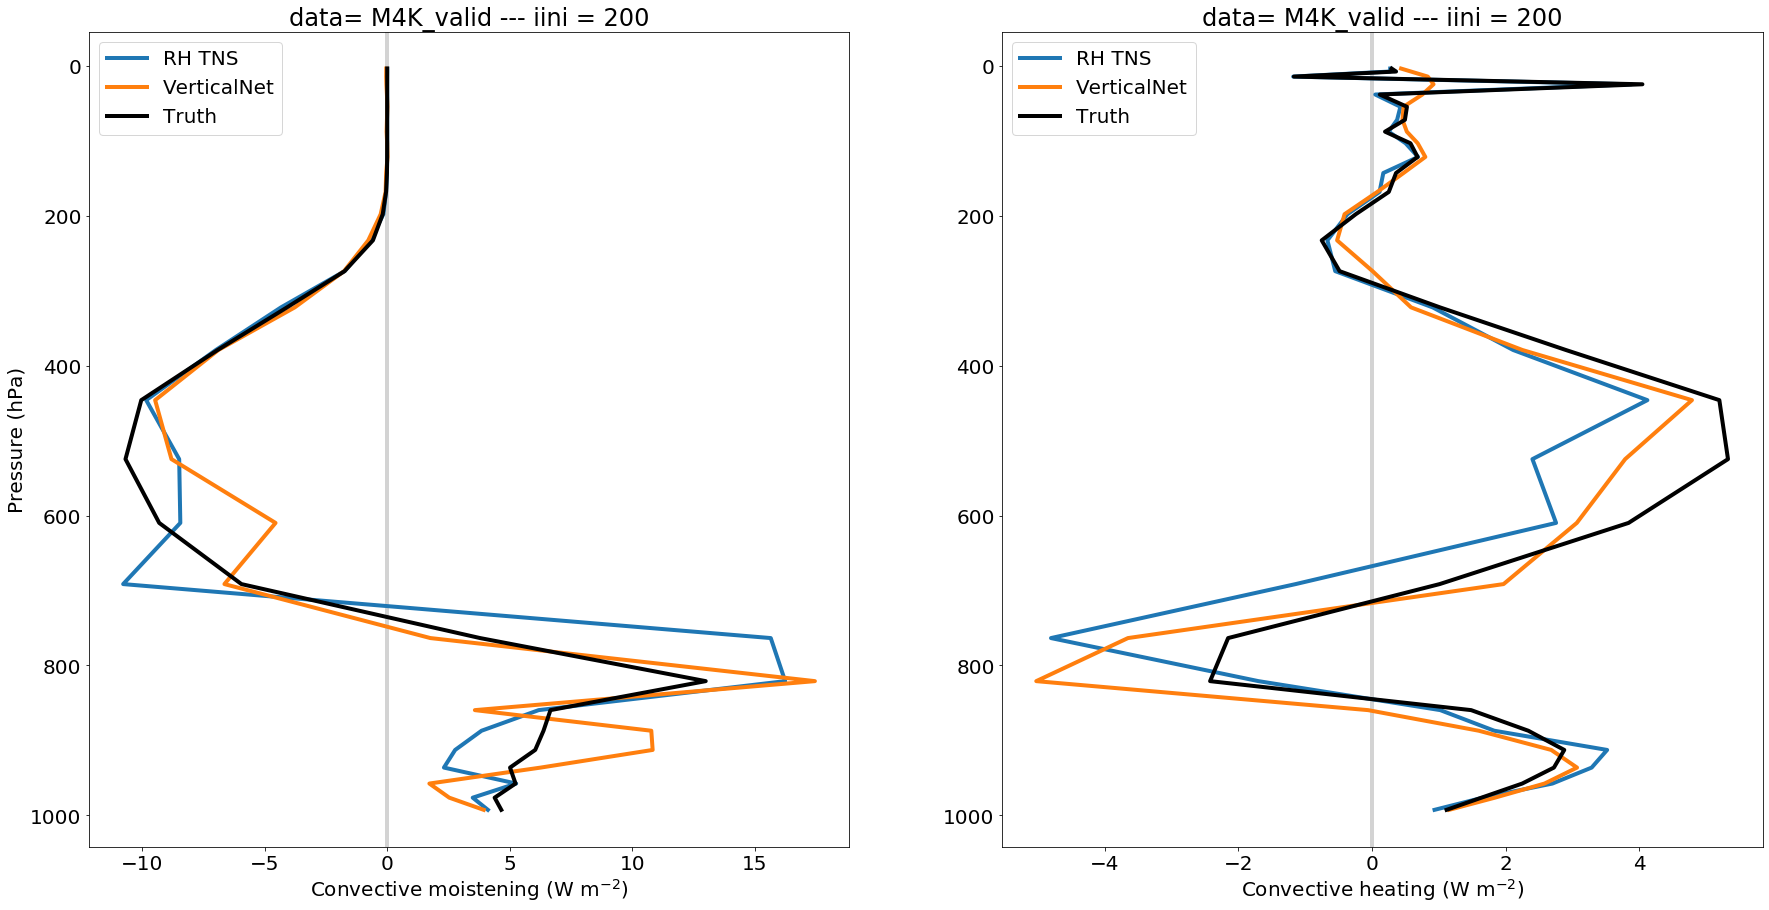

In [93]:


data = 'M4K_valid'
plt.figure(figsize=(30,15))
iini = iinis[0]
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
plt.title('data= '+data+' '+ '--- iini = '+str(iini))


plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()


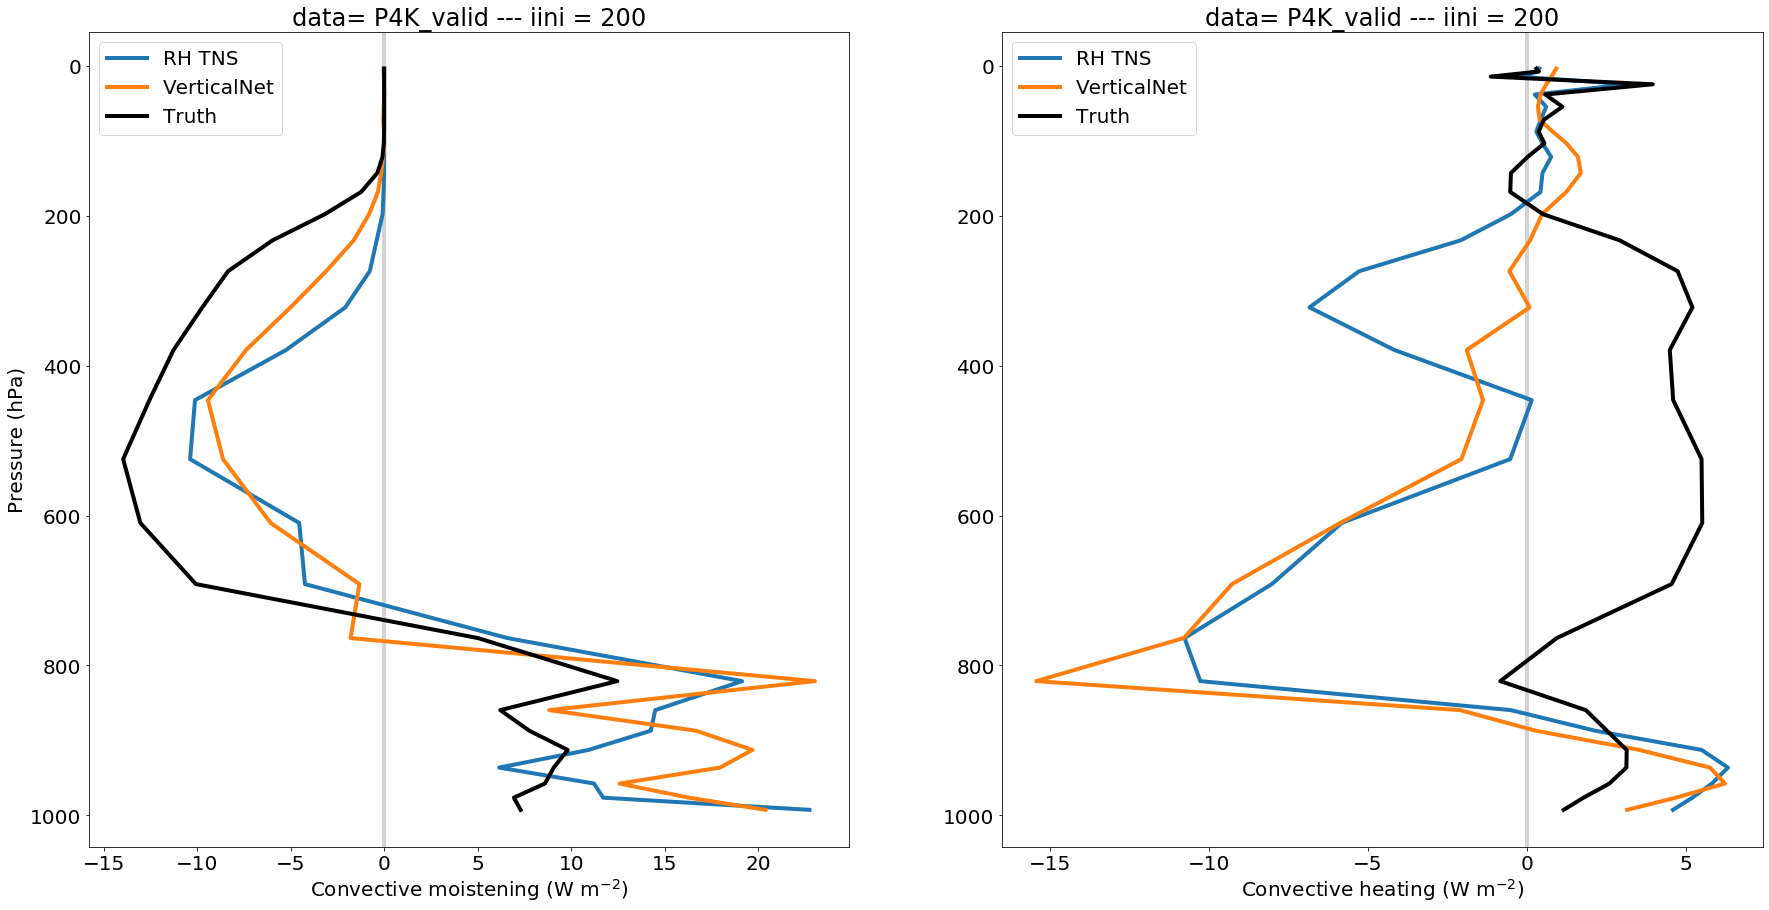

In [94]:


data = 'P4K_valid'
plt.figure(figsize=(30,15))
iini = iinis[0]
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
plt.title('data= '+data+' '+ '--- iini = '+str(iini))


plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()


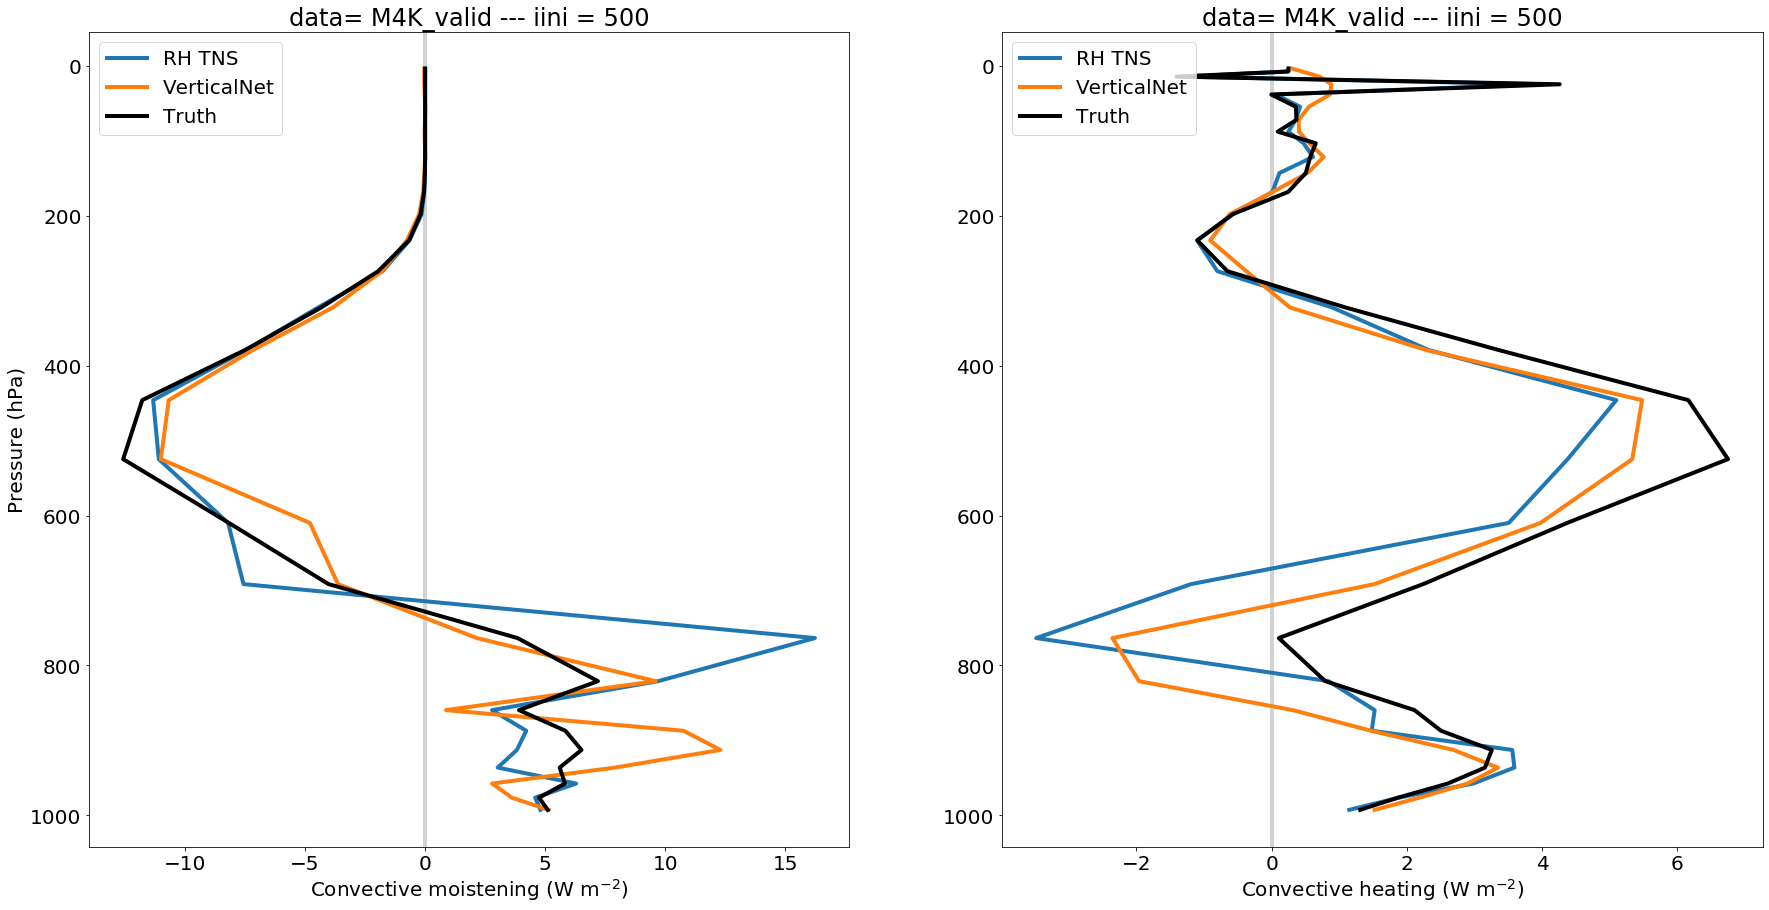

In [95]:


data = 'M4K_valid'
plt.figure(figsize=(30,15))
iini = iinis[1]
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
plt.title('data= '+data+' '+ '--- iini = '+str(iini))


plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()


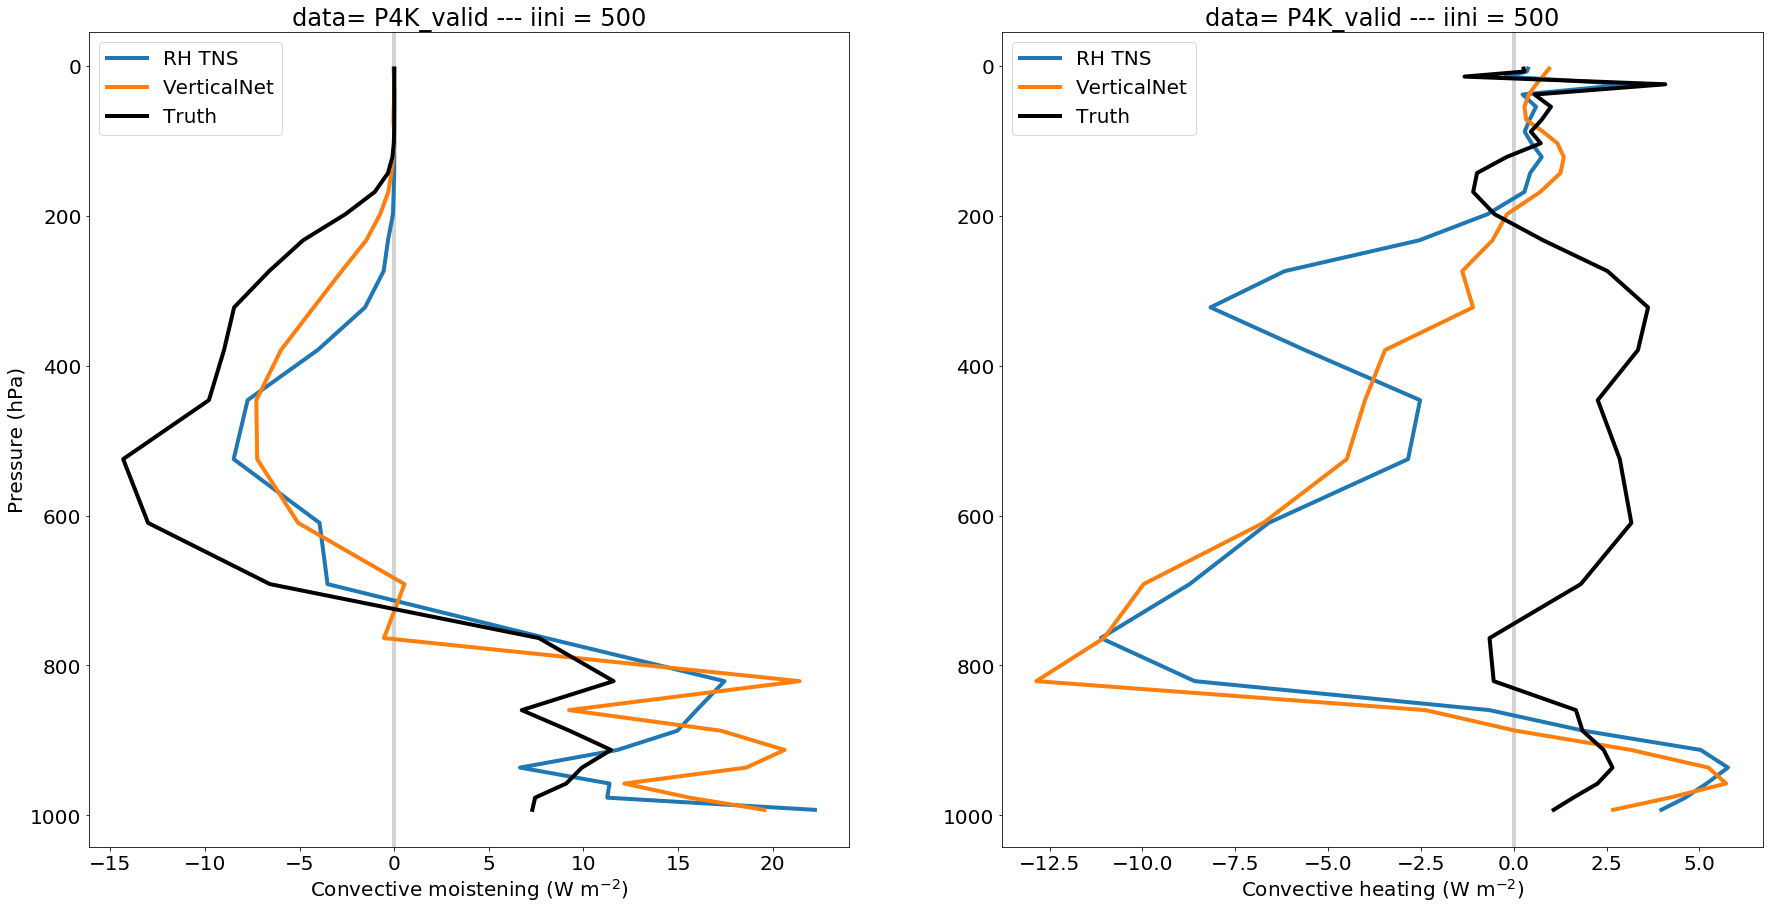

In [96]:


data = 'P4K_valid'
plt.figure(figsize=(30,15))
iini = iinis[1]
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
plt.title('data= '+data+' '+ '--- iini = '+str(iini))


plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()
